In [1]:
competition_name = "datathonindoml-2022"

# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "/content/kaggle.json"

! pip install kaggle --quiet

! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c {competition_name}

! mkdir kaggle_data
! unzip {competition_name + ".zip"} -d kaggle_data

# Unmount Google Drive
drive.flush_and_unmount()

Streaming output truncated to the last 5000 lines.
  inflating: kaggle_data/train/train/6309.tif  
  inflating: kaggle_data/train/train/631.tif  
  inflating: kaggle_data/train/train/6310.tif  
  inflating: kaggle_data/train/train/6311.tif  
  inflating: kaggle_data/train/train/6312.tif  
  inflating: kaggle_data/train/train/6313.tif  
  inflating: kaggle_data/train/train/6314.tif  
  inflating: kaggle_data/train/train/6315.tif  
  inflating: kaggle_data/train/train/6316.tif  
  inflating: kaggle_data/train/train/6317.tif  
  inflating: kaggle_data/train/train/6318.tif  
  inflating: kaggle_data/train/train/6319.tif  
  inflating: kaggle_data/train/train/632.tif  
  inflating: kaggle_data/train/train/6320.tif  
  inflating: kaggle_data/train/train/6321.tif  
  inflating: kaggle_data/train/train/6322.tif  
  inflating: kaggle_data/train/train/6323.tif  
  inflating: kaggle_data/train/train/6324.tif  
  inflating: kaggle_data/train/train/6325.tif  
  inflating: kaggle_data/train/train/63

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

In [98]:
# datasets
labels = pd.read_csv("/content/kaggle_data/train_labels.csv")
sample = pd.read_csv('/content/kaggle_data/sample_submission.csv')

# folders paths
train_path = "/content/kaggle_data/train/train"
test_path = "/content/kaggle_data/validation/validation"

In [99]:
labels.head()

,id,label
0,0,1
1,1,13
2,2,13
3,3,14
4,4,6


Adding .tif to each id and converting label to string to ease retreiving of data

In [100]:
def to_tif(id):
  return str(id)+'.tif'

def label_str(label):
  return str(label)

labels['id'] = labels['id'].apply(to_tif)
labels['label'] = labels['label'].apply(label_str)

labels.head()

,id,label
0,0.tif,1
1,1.tif,13
2,2.tif,13
3,3.tif,14
4,4.tif,6


##Augmenting Data:

It’s a pre-processing technique in which we augment the existing dataset with transformed versions of the existing images. We can perform scaling, rotations, increasing brightness, and other affine transformations. This is a useful technique as it helps the model to generalize the unseen data well.

ImageDataGenerator class is used for this purpose which provides a real-time augmentation of data.

Description of few of its parameters that are used below:

`rescale` : rescales values by the given factor.

`horizontal_flip` : randomly flip inputs horizontally.

`validation_split` : this is the fraction of images reserved for validation (between 0 and 1).

In [101]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split = 0.2 # training: 80% data, validation: 20% data
                 )

train_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'label',
    subset="training",
    color_mode="rgb",
    target_size = (128,128), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

validation_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'label',
    subset="validation",
    color_mode="rgb",
    target_size = (128,128), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 12800 validated image filenames belonging to 16 classes.
Found 3200 validated image filenames belonging to 16 classes.


Plotting images from the train data set:

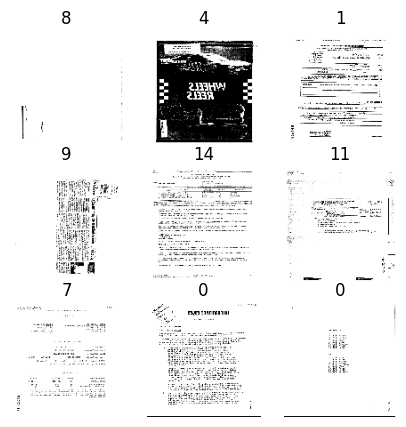

In [102]:
x,y = next(train_generator)

a = train_generator.class_indices
class_names = list(a.keys())  # storing class names in a list

def plot_images(img, labels):
  plt.figure(figsize=[5, 5])
  for i in range(9):
      plt.subplot(3, 3, i+1)
      plt.imshow(img[i])
      plt.title(class_names[np.argmax(labels[i])])
      plt.axis('off')
plot_images(x,y)

In [109]:
from keras.optimizers import Adam
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 128,128
batch_size = 32
epochs = 50


model = keras.applications.inception_resnet_v2.InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (None,None, 3),)


In [110]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
mcp_save = ModelCheckpoint('model_1.hdf5', save_best_only=True, monitor='acc', mode='max')

In [111]:
from keras.layers import GlobalAveragePooling2D
for layer in model.layers:
    layer.trainable=True

#Adding custom Layers
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model
model_final = Model(model.input, predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy", optimizer =Adam(lr=0.0001), metrics=["accuracy"])

In [112]:
model_final.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_500 (Conv2D)            (None, None, None,   864         ['input_9[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_504 (Batch  (None, None, None,   96         ['conv2d_500[0][0]']             
 Normalization)                 32)                                                         

In [113]:
model_final.fit(
train_generator,
steps_per_epoch =12800//32,
epochs=25,
validation_data=validation_generator,
validation_steps=3200//32,
callbacks=[reduce_lr,mcp_save])

Epoch 1/25
400/400 [==============================] - ETA: 0s - loss: 2.4702 - accuracy: 0.2167

400/400 [==============================] - 121s 243ms/step - loss: 2.4702 - accuracy: 0.2167 - val_loss: 1.9836 - val_accuracy: 0.4363 - lr: 1.0000e-04
Epoch 2/25
400/400 [==============================] - ETA: 0s - loss: 1.8521 - accuracy: 0.4391

400/400 [==============================] - 92s 229ms/step - loss: 1.8521 - accuracy: 0.4391 - val_loss: 1.5062 - val_accuracy: 0.5597 - lr: 1.0000e-04
Epoch 3/25
400/400 [==============================] - ETA: 0s - loss: 1.5124 - accuracy: 0.5511

400/400 [==============================] - 91s 228ms/step - loss: 1.5124 - accuracy: 0.5511 - val_loss: 1.3397 - val_accuracy: 0.6150 - lr: 1.0000e-04
Epoch 4/25
400/400 [==============================] - ETA: 0s - loss: 1.2878 - accuracy: 0.6213

400/400 [==============================] - 91s 228ms/step - loss: 1.2878 - accuracy: 0.6213 - val_loss: 1.3008 - val_accuracy: 0.6263 - lr: 1.0000e-04
Epoch 5/25
400/400 [==============================] - ETA: 0s - loss: 1.0938 - accuracy: 0.6870

400/400 [==============================] - 91s 228ms/step - loss: 1.0938 - accuracy: 0.6870 - val_loss: 1.3072 - val_accuracy: 0.6359 - lr: 1.0000e-04
Epoch 6/25
400/400 [==============================] - ETA: 0s - loss: 0.9422 - accuracy: 0.7336

400/400 [==============================] - 91s 228ms/step - loss: 0.9422 - accuracy: 0.7336 - val_loss: 1.2054 - val_accuracy: 0.6694 - lr: 1.0000e-04
Epoch 7/25
400/400 [==============================] - ETA: 0s - loss: 0.7840 - accuracy: 0.7802

400/400 [==============================] - 100s 251ms/step - loss: 0.7840 - accuracy: 0.7802 - val_loss: 1.2788 - val_accuracy: 0.6653 - lr: 1.0000e-04
Epoch 8/25
400/400 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.8168

400/400 [==============================] - 91s 228ms/step - loss: 0.6634 - accuracy: 0.8168 - val_loss: 1.3244 - val_accuracy: 0.6575 - lr: 1.0000e-04
Epoch 9/25
400/400 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.8726

400/400 [==============================] - 92s 229ms/step - loss: 0.4552 - accuracy: 0.8726 - val_loss: 1.2294 - val_accuracy: 0.6894 - lr: 2.0000e-05
Epoch 10/25
400/400 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.9066

400/400 [==============================] - 92s 229ms/step - loss: 0.3474 - accuracy: 0.9066 - val_loss: 1.2799 - val_accuracy: 0.6950 - lr: 2.0000e-05
Epoch 11/25
400/400 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.9242

400/400 [==============================] - 92s 230ms/step - loss: 0.2834 - accuracy: 0.9242 - val_loss: 1.2982 - val_accuracy: 0.6919 - lr: 4.0000e-06
Epoch 12/25
400/400 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.9280

400/400 [==============================] - 92s 229ms/step - loss: 0.2616 - accuracy: 0.9280 - val_loss: 1.3214 - val_accuracy: 0.6956 - lr: 4.0000e-06
Epoch 13/25
400/400 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9327

400/400 [==============================] - 91s 228ms/step - loss: 0.2483 - accuracy: 0.9327 - val_loss: 1.3325 - val_accuracy: 0.6959 - lr: 1.0000e-06
Epoch 14/25
400/400 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9295

400/400 [==============================] - 92s 230ms/step - loss: 0.2520 - accuracy: 0.9295 - val_loss: 1.3348 - val_accuracy: 0.6922 - lr: 1.0000e-06
Epoch 15/25
400/400 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.9343

400/400 [==============================] - 91s 228ms/step - loss: 0.2427 - accuracy: 0.9343 - val_loss: 1.3376 - val_accuracy: 0.6931 - lr: 1.0000e-06
Epoch 16/25
400/400 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9352

400/400 [==============================] - 91s 228ms/step - loss: 0.2366 - accuracy: 0.9352 - val_loss: 1.3177 - val_accuracy: 0.7016 - lr: 1.0000e-06
Epoch 17/25
400/400 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9384

400/400 [==============================] - 92s 231ms/step - loss: 0.2295 - accuracy: 0.9384 - val_loss: 1.3270 - val_accuracy: 0.6975 - lr: 1.0000e-06
Epoch 18/25
400/400 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.9372

400/400 [==============================] - 92s 229ms/step - loss: 0.2229 - accuracy: 0.9372 - val_loss: 1.3513 - val_accuracy: 0.6966 - lr: 1.0000e-06
Epoch 19/25
400/400 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.9373

400/400 [==============================] - 92s 231ms/step - loss: 0.2229 - accuracy: 0.9373 - val_loss: 1.3576 - val_accuracy: 0.6934 - lr: 1.0000e-06
Epoch 20/25
400/400 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9402

400/400 [==============================] - 92s 230ms/step - loss: 0.2193 - accuracy: 0.9402 - val_loss: 1.3457 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 21/25
400/400 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.9402

400/400 [==============================] - 101s 252ms/step - loss: 0.2111 - accuracy: 0.9402 - val_loss: 1.3825 - val_accuracy: 0.6934 - lr: 1.0000e-06
Epoch 22/25
400/400 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9433

400/400 [==============================] - 92s 230ms/step - loss: 0.2104 - accuracy: 0.9433 - val_loss: 1.3890 - val_accuracy: 0.6969 - lr: 1.0000e-06
Epoch 23/25
400/400 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.9431

400/400 [==============================] - 93s 233ms/step - loss: 0.2057 - accuracy: 0.9431 - val_loss: 1.3876 - val_accuracy: 0.6947 - lr: 1.0000e-06
Epoch 24/25
400/400 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9427

400/400 [==============================] - 93s 232ms/step - loss: 0.2018 - accuracy: 0.9427 - val_loss: 1.3667 - val_accuracy: 0.6919 - lr: 1.0000e-06
Epoch 25/25
400/400 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9420

400/400 [==============================] - 93s 233ms/step - loss: 0.2044 - accuracy: 0.9420 - val_loss: 1.3918 - val_accuracy: 0.6916 - lr: 1.0000e-06
